In [6]:
# install packages (if necessary)
import sys
!{sys.executable} -m pip install wordcloud --user
!{sys.executable} -m pip install selenium --user
!{sys.executable} -m pip install textblob --user

In [1]:
# import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# To mock web-browser and scrape tweets
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\XV60\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\XV60\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\XV60\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\XV60\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\XV60\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\XV60\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already u

In [2]:
####input your credentials here
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

In [3]:
class SeleniumClient(object):
    def __init__(self):
        #Initialization method. 
        self.chrome_options = webdriver.ChromeOptions()
        self.chrome_options.add_argument('--headless')
        self.chrome_options.add_argument('--no-sandbox')
        self.chrome_options.add_argument('--disable-setuid-sandbox')

        # you need to provide the path of chromdriver in your system
        self.browser = webdriver.Chrome('D:/chromedriver_win32/chromedriver', options=self.chrome_options)

        self.base_url = 'https://twitter.com/search?q='

    def get_tweets(self, query):
        #Function to fetch tweets. 
        try: 
            self.browser.get(self.base_url+query)
            time.sleep(2)

            body = self.browser.find_element_by_tag_name('body')

            for _ in range(3000):
                body.send_keys(Keys.PAGE_DOWN)
                time.sleep(0.3)

            timeline = self.browser.find_element_by_id('timeline')
            tweet_nodes = timeline.find_elements_by_css_selector('.tweet-text')

            return pd.DataFrame({'tweets': [tweet_node.text for tweet_node in tweet_nodes]})

        except:
            print("Selenium - An error occured while fetching tweets.")

In [73]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = []
        dates = []
        geo = []
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break
#Modded
                for tweet in new_tweets:
                    parsed_tweet = {} 
                    date_tweet = {}
                    geo_tweet = {}
                    parsed_tweet['tweets'],date_tweet['create_time'],geo_tweet['create_place'] = tweet.text,tweet.created_at,tweet.place

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet)
                            dates.append(date_tweet)
                            geo.append(geo_tweet)
                    else: 
                        tweets.append(parsed_tweet)
                        dates.append(date_tweet)
                        geo.append(geo_tweet)
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        tweets = pd.DataFrame(tweets)
        create_time = pd.DataFrame(dates)
        create_place = pd.DataFrame(geo)
        
        return pd.concat([tweets, create_time, create_place], axis=1)

In [74]:
# enter keywords to search for here

search_terms = 'beer'

In [122]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets(search_terms, maxTweets=300)
print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df.head(10)

Downloaded 100 tweets
Downloaded 200 tweets
tweets_df Shape - (144, 3)


tweets         create_time  \
0  When your classmate is shirtless and drinking ... 2020-05-27 14:35:34   
1  RT @holdmyale: Hold my beer while I go fishing... 2020-05-27 14:35:33   
2  @Grimmy_Coyote Ugh! I’m over beer that tastes ... 2020-05-27 14:35:33   
3                            @econympho Beer o’clock 2020-05-27 14:35:32   
4  RT @cervezadviernes: La cerveza puertollanera ... 2020-05-27 14:35:31   
5  RT @ML_Musik: I lowkey wanna start a beer comp... 2020-05-27 14:35:30   
6  @beer_net @PeoplesMomentum You’re the type of ... 2020-05-27 14:35:29   
7                             @beer_skfn チャージライフルっぽい 2020-05-27 14:35:29   
8  RT @SkewSpew: @davemacladd America: we're goin... 2020-05-27 14:35:28   
9  @insignificuntxX Fucking body shaming.\nI don'... 2020-05-27 14:35:28   

  create_place  
0         None  
1         None  
2         None  
3         None  
4         None  
5         None  
6         None  
7         None  
8         None  
9         None

In [125]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return polarity_scores

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [129]:
# In progress -- trying to get detailed polrity data vs. original simplified pos/neg classification
sentiments_using_SIA = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame.from_records(sentiments_using_SIA)

neg    neu    pos  compound
0    0.000  1.000  0.000    0.0000
1    0.000  1.000  0.000    0.0000
2    0.111  0.635  0.254    0.5562
3    0.000  1.000  0.000    0.0000
4    0.000  1.000  0.000    0.0000
..     ...    ...    ...       ...
139  0.000  1.000  0.000    0.0000
140  0.000  1.000  0.000    0.0000
141  0.000  0.894  0.106    0.3612
142  0.000  1.000  0.000    0.0000
143  0.000  1.000  0.000    0.0000

[144 rows x 4 columns]

In [132]:
sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob)

tweets
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
..      ...
139     0.0
140     0.0
141     0.0
142     0.0
143     0.0

[144 rows x 1 columns]

In [133]:
tweets_df['sentiment'] = sentiments_using_textblob
tweets_df.head()

tweets         create_time  \
0  When your classmate is shirtless and drinking ... 2020-05-27 14:35:34   
1  RT @holdmyale: Hold my beer while I go fishing... 2020-05-27 14:35:33   
2  @Grimmy_Coyote Ugh! I’m over beer that tastes ... 2020-05-27 14:35:33   
3                            @econympho Beer o’clock 2020-05-27 14:35:32   
4  RT @cervezadviernes: La cerveza puertollanera ... 2020-05-27 14:35:31   

  create_place  sentiment  
0         None        0.0  
1         None        0.0  
2         None        0.0  
3         None        0.0  
4         None        0.0

In [81]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [82]:
# adds cleaned tweets into a new column called 'tidy_tweets'
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
tweets_df.head(10)

tweets         create_time  \
0                 @jeonbuhni Oil cleansers are beer. 2020-05-26 22:45:23   
1  Pike really be like “you’re being mean to me f... 2020-05-26 22:45:22   
2  it's an amazing idea to add a spoonful of east... 2020-05-26 22:45:21   
3  RT @Kirin_Brewery: ／\nおうちで #本麒麟 を愉しみましょう❗️\n#本... 2020-05-26 22:45:21   
4  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa... 2020-05-26 22:45:21   
5  madison beer patrimonio dell'umanità PERIODT\n... 2020-05-26 22:45:20   
6  @PURIN08081 \nご参加ありがとうございます❗\n\n結果は動画でご確認ください☺... 2020-05-26 22:45:19   
7  @StephaliciousD the majority? no. A majority? ... 2020-05-26 22:45:19   
8  RT @Bike_Odyssey: Chat with a historian, lunch... 2020-05-26 22:45:19   
9  @DLoesch Hey @ABC7NY  does it include beer and... 2020-05-26 22:45:18   

  create_place sentiment                                        tidy_tweets  
0         None       pos                 @jeonbuhni Oil cleansers are beer.  
1         None       neg  Pike really be like “you’re being mean to me f...  
2         None       pos  it's an amazing idea to add a spoonful of east...  
3         None       pos   ／\nおうちで #本麒麟 を愉しみましょう❗️\n#本麒麟早くも11億本突破 ❗️\n＼\...  
4         None       neg  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa...  
5         None       pos  madison beer patrimonio dell'umanità PEIODT\n\...  
6         None       pos  @PUIN08081 \nご参加ありがとうございます❗\n\n結果は動画でご確認ください☺\...  
7         None       neg  @StephaliciousD the majority? no. A majority? ...  
8         None       pos   Chat with a historian, lunch with a sommelier...  
9         None       pos  @DLoesch Hey @ABC7NY  does it include beer and...

In [83]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # filter out all the words that contains a link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

tweets         create_time  \
0                 @jeonbuhni Oil cleansers are beer. 2020-05-26 22:45:23   
1  Pike really be like “you’re being mean to me f... 2020-05-26 22:45:22   
2  it's an amazing idea to add a spoonful of east... 2020-05-26 22:45:21   
3  RT @Kirin_Brewery: ／\nおうちで #本麒麟 を愉しみましょう❗️\n#本... 2020-05-26 22:45:21   
4  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa... 2020-05-26 22:45:21   
5  madison beer patrimonio dell'umanità PERIODT\n... 2020-05-26 22:45:20   
6  @PURIN08081 \nご参加ありがとうございます❗\n\n結果は動画でご確認ください☺... 2020-05-26 22:45:19   
7  @StephaliciousD the majority? no. A majority? ... 2020-05-26 22:45:19   
8  RT @Bike_Odyssey: Chat with a historian, lunch... 2020-05-26 22:45:19   
9  @DLoesch Hey @ABC7NY  does it include beer and... 2020-05-26 22:45:18   

  create_place sentiment                                        tidy_tweets  
0         None       pos                 @jeonbuhni Oil cleansers are beer.  
1         None       neg  Pike really be like “you’re being mean to me f...  
2         None       pos  it's an amazing idea to add a spoonful of east...  
3         None       pos  ／ おうちで #本麒麟 を愉しみましょう❗️ #本麒麟早くも11億本突破 ❗️ ＼ 新しい ...  
4         None       neg  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa...  
5         None       pos        madison beer patrimonio dell'umanità PEIODT  
6         None       pos  @PUIN08081 ご参加ありがとうございます❗ 結果は動画でご確認ください☺ 当たりの方...  
7         None       neg  @StephaliciousD the majority? no. A majority? ...  
8         None       pos  Chat with a historian, lunch with a sommelier,...  
9         None       pos  @DLoesch Hey @ABC7NY does it include beer and ...

In [84]:
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']
tweets_df.head()

tweets         create_time  \
0                 @jeonbuhni Oil cleansers are beer. 2020-05-26 22:45:23   
1  Pike really be like “you’re being mean to me f... 2020-05-26 22:45:22   
2  it's an amazing idea to add a spoonful of east... 2020-05-26 22:45:21   
3  RT @Kirin_Brewery: ／\nおうちで #本麒麟 を愉しみましょう❗️\n#本... 2020-05-26 22:45:21   
4  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa... 2020-05-26 22:45:21   

  create_place sentiment                                        tidy_tweets  
0         None       pos                 @jeonbuhni Oil cleansers are beer.  
1         None       neg  Pike really be like “you’re being mean to me f...  
2         None       pos  it's an amazing idea to add a spoonful of east...  
3         None       pos  ／ おうちで #本麒麟 を愉しみましょう❗️ #本麒麟早くも11億本突破 ❗️ ＼ 新しい ...  
4         None       neg  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa...

In [85]:
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets_df.head()

tweets         create_time  \
0                 @jeonbuhni Oil cleansers are beer. 2020-05-26 22:45:23   
1  Pike really be like “you’re being mean to me f... 2020-05-26 22:45:22   
2  it's an amazing idea to add a spoonful of east... 2020-05-26 22:45:21   
3  RT @Kirin_Brewery: ／\nおうちで #本麒麟 を愉しみましょう❗️\n#本... 2020-05-26 22:45:21   
4  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa... 2020-05-26 22:45:21   

  create_place sentiment                                        tidy_tweets  
0         None       pos                 @jeonbuhni Oil cleansers are beer.  
1         None       neg  Pike really be like “you’re being mean to me f...  
2         None       pos  it's an amazing idea to add a spoonful of east...  
3         None       pos  ／ おうちで #本麒麟 を愉しみましょう❗️ #本麒麟早くも11億本突破 ❗️ ＼ 新しい ...  
4         None       neg  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa...

In [86]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.head()

tweets         create_time  \
0                 @jeonbuhni Oil cleansers are beer. 2020-05-26 22:45:23   
1  Pike really be like “you’re being mean to me f... 2020-05-26 22:45:22   
2  it's an amazing idea to add a spoonful of east... 2020-05-26 22:45:21   
3  RT @Kirin_Brewery: ／\nおうちで #本麒麟 を愉しみましょう❗️\n#本... 2020-05-26 22:45:21   
4  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa... 2020-05-26 22:45:21   

  create_place sentiment                                        tidy_tweets  
0         None       pos                 @jeonbuhni Oil cleansers are beer.  
1         None       neg  Pike really be like “you’re being mean to me f...  
2         None       pos  it's an amazing idea to add a spoonful of east...  
3         None       pos  ／ おうちで #本麒麟 を愉しみましょう❗️ #本麒麟早くも11億本突破 ❗️ ＼ 新しい ...  
4         None       neg  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa...

In [87]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

In [88]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filtering out stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # create tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['absolute_tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

tweets         create_time  \
0                 @jeonbuhni Oil cleansers are beer. 2020-05-26 22:45:23   
1  Pike really be like “you’re being mean to me f... 2020-05-26 22:45:22   
2  it's an amazing idea to add a spoonful of east... 2020-05-26 22:45:21   
3  RT @Kirin_Brewery: ／\nおうちで #本麒麟 を愉しみましょう❗️\n#本... 2020-05-26 22:45:21   
4  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa... 2020-05-26 22:45:21   
5  madison beer patrimonio dell'umanità PERIODT\n... 2020-05-26 22:45:20   
6  @PURIN08081 \nご参加ありがとうございます❗\n\n結果は動画でご確認ください☺... 2020-05-26 22:45:19   
7  @StephaliciousD the majority? no. A majority? ... 2020-05-26 22:45:19   
8  RT @Bike_Odyssey: Chat with a historian, lunch... 2020-05-26 22:45:19   
9  @DLoesch Hey @ABC7NY  does it include beer and... 2020-05-26 22:45:18   

  create_place sentiment                                        tidy_tweets  \
0         None       pos                 @jeonbuhni Oil cleansers are beer.   
1         None       neg  Pike really be like “you’re being mean to me f...   
2         None       pos  it's an amazing idea to add a spoonful of east...   
3         None       pos  ／ おうちで #本麒麟 を愉しみましょう❗️ #本麒麟早くも11億本突破 ❗️ ＼ 新しい ...   
4         None       neg  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa...   
5         None       pos        madison beer patrimonio dell'umanità PEIODT   
6         None       pos  @PUIN08081 ご参加ありがとうございます❗ 結果は動画でご確認ください☺ 当たりの方...   
7         None       neg  @StephaliciousD the majority? no. A majority? ...   
8         None       pos  Chat with a historian, lunch with a sommelier,...   
9         None       pos  @DLoesch Hey @ABC7NY does it include beer and ...   

                                absolute_tidy_tweets  
0                       jeonbuhni Oil cleansers beer  
1  Pike really like youre mean exposing I bad dan...  
2  amazing idea add spoonful east asian pepper oa...  
3                                    ml KirinBrewery  
4  eipemilyek lamontstewart ThisJustin washington...  
5          madison beer patrimonio dellumanit PEIODT  
6                                            PUIN DM  
7  StephaliciousD majority A majority well yes me...  
8  Chat historian lunch sommelier beer brewer tou...  
9  DLoesch Hey ABCNY include beer Jello pool friends

In [89]:
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0                    [jeonbuhni, Oil, cleansers, beer]
1    [Pike, really, like, youre, mean, exposing, I,...
2    [amazing, idea, add, spoonful, east, asian, pe...
3                                   [ml, KirinBrewery]
4    [eipemilyek, lamontstewart, ThisJustin, washin...
Name: absolute_tidy_tweets, dtype: object

In [90]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0                     [jeonbuhni, Oil, cleanser, beer]
1    [Pike, really, like, youre, mean, exposing, I,...
2    [amazing, idea, add, spoonful, east, asian, pe...
3                                   [ml, KirinBrewery]
4    [eipemilyek, lamontstewart, ThisJustin, washin...
Name: absolute_tidy_tweets, dtype: object

In [91]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet
tweets_df.head(10)

tweets         create_time  \
0                 @jeonbuhni Oil cleansers are beer. 2020-05-26 22:45:23   
1  Pike really be like “you’re being mean to me f... 2020-05-26 22:45:22   
2  it's an amazing idea to add a spoonful of east... 2020-05-26 22:45:21   
3  RT @Kirin_Brewery: ／\nおうちで #本麒麟 を愉しみましょう❗️\n#本... 2020-05-26 22:45:21   
4  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa... 2020-05-26 22:45:21   
5  madison beer patrimonio dell'umanità PERIODT\n... 2020-05-26 22:45:20   
6  @PURIN08081 \nご参加ありがとうございます❗\n\n結果は動画でご確認ください☺... 2020-05-26 22:45:19   
7  @StephaliciousD the majority? no. A majority? ... 2020-05-26 22:45:19   
8  RT @Bike_Odyssey: Chat with a historian, lunch... 2020-05-26 22:45:19   
9  @DLoesch Hey @ABC7NY  does it include beer and... 2020-05-26 22:45:18   

  create_place sentiment                                        tidy_tweets  \
0         None       pos                 @jeonbuhni Oil cleansers are beer.   
1         None       neg  Pike really be like “you’re being mean to me f...   
2         None       pos  it's an amazing idea to add a spoonful of east...   
3         None       pos  ／ おうちで #本麒麟 を愉しみましょう❗️ #本麒麟早くも11億本突破 ❗️ ＼ 新しい ...   
4         None       neg  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa...   
5         None       pos        madison beer patrimonio dell'umanità PEIODT   
6         None       pos  @PUIN08081 ご参加ありがとうございます❗ 結果は動画でご確認ください☺ 当たりの方...   
7         None       neg  @StephaliciousD the majority? no. A majority? ...   
8         None       pos  Chat with a historian, lunch with a sommelier,...   
9         None       pos  @DLoesch Hey @ABC7NY does it include beer and ...   

                                absolute_tidy_tweets  
0                        jeonbuhni Oil cleanser beer  
1  Pike really like youre mean exposing I bad dan...  
2  amazing idea add spoonful east asian pepper oa...  
3                                    ml KirinBrewery  
4  eipemilyek lamontstewart ThisJustin washington...  
5          madison beer patrimonio dellumanit PEIODT  
6                                            PUIN DM  
7  StephaliciousD majority A majority well yes me...  
8  Chat historian lunch sommelier beer brewer tou...  
9   DLoesch Hey ABCNY include beer Jello pool friend

In [92]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

In [93]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [94]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows(): 
    toks = nltk.regexp_tokenize(row.tidy_tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['jeonbuhni oil cleanser', 'beer'],
 ['pike', 'mean', 'dangerous thing'],
 ['amazing idea', 'spoonful', 'east asian pepper', 'oat beer', 'opinion'],
 ['おうちで 本麒麟 を愉しみましょう 本麒麟早くも11億本突破 新しい',
  'をしてその場で結果をチェック 参加方法 👇 ①@ kirin_breweryをフ'],
 ['eipemilyek', ' @_t hisjustin_', 'supporter'],
 ['madison beer patrimonio dell', 'umanità  pei odt'],
 ['@pui n08081 ご参加ありがとうございます 結果は動画でご確認ください 当たりの方にはdmが届きます このキャンペーンは5 /31(',
  'こちらもぜひ'],
 ['stephaliciousd', 'majority', 'majority', 'estimate'],
 ['chat', 'lunch', 'sommelier', 'beer', 'brewer', 'tour'],
 ['dloesch hey  @ab c7ny', 'beer', ' a j', 'pool', 'friend']]

In [95]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets_df.iterrows():
    # filtering out hashtags
    words_without_hash = [word for word in row.tidy_tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['jeonbuhni oil cleansers'],
 ['pike', '’ re', 'dangerous thing 😭😭😭'],
 ['amazing idea', 'east asian pepper', 'oat beer'],
 ['／ おうちで を愉しみましょう❗️ ❗️ ＼ 新しい 350ml缶×6本が抽選で1000名様に当たる❗️ をしてその場で結果をチェック👀 参加方法👇 ①@kirin_breweryをフ…'],
 ['_ thisjustin _', 'k…'],
 ['madison beer patrimonio dell', "' umanità peiodt"],
 ['puin08081 ご参加ありがとうございます❗ 結果は動画でご確認ください☺ 当たりの方にはdmが届きます✨ このキャンペーンは5/31(日)23:59まで毎日チャレンジできます❕ こちらもぜひ！…'],
 [],
 ['venetian'],
 ['jello pool']]

In [96]:
tweets_df['key_phrases'] = textblob_key_phrases
tweets_df.head(10)

tweets         create_time  \
0                 @jeonbuhni Oil cleansers are beer. 2020-05-26 22:45:23   
1  Pike really be like “you’re being mean to me f... 2020-05-26 22:45:22   
2  it's an amazing idea to add a spoonful of east... 2020-05-26 22:45:21   
3  RT @Kirin_Brewery: ／\nおうちで #本麒麟 を愉しみましょう❗️\n#本... 2020-05-26 22:45:21   
4  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa... 2020-05-26 22:45:21   
5  madison beer patrimonio dell'umanità PERIODT\n... 2020-05-26 22:45:20   
6  @PURIN08081 \nご参加ありがとうございます❗\n\n結果は動画でご確認ください☺... 2020-05-26 22:45:19   
7  @StephaliciousD the majority? no. A majority? ... 2020-05-26 22:45:19   
8  RT @Bike_Odyssey: Chat with a historian, lunch... 2020-05-26 22:45:19   
9  @DLoesch Hey @ABC7NY  does it include beer and... 2020-05-26 22:45:18   

  create_place sentiment                                        tidy_tweets  \
0         None       pos                 @jeonbuhni Oil cleansers are beer.   
1         None       neg  Pike really be like “you’re being mean to me f...   
2         None       pos  it's an amazing idea to add a spoonful of east...   
3         None       pos  ／ おうちで #本麒麟 を愉しみましょう❗️ #本麒麟早くも11億本突破 ❗️ ＼ 新しい ...   
4         None       neg  @eipemilyek @lamontstewart17 @_ThisJustin_ @wa...   
5         None       pos        madison beer patrimonio dell'umanità PEIODT   
6         None       pos  @PUIN08081 ご参加ありがとうございます❗ 結果は動画でご確認ください☺ 当たりの方...   
7         None       neg  @StephaliciousD the majority? no. A majority? ...   
8         None       pos  Chat with a historian, lunch with a sommelier,...   
9         None       pos  @DLoesch Hey @ABC7NY does it include beer and ...   

                                absolute_tidy_tweets  \
0                        jeonbuhni Oil cleanser beer   
1  Pike really like youre mean exposing I bad dan...   
2  amazing idea add spoonful east asian pepper oa...   
3                                    ml KirinBrewery   
4  eipemilyek lamontstewart ThisJustin washington...   
5          madison beer patrimonio dellumanit PEIODT   
6                                            PUIN DM   
7  StephaliciousD majority A majority well yes me...   
8  Chat historian lunch sommelier beer brewer tou...   
9   DLoesch Hey ABCNY include beer Jello pool friend   

                                         key_phrases  
0                          [jeonbuhni oil cleansers]  
1                  [pike, ’ re, dangerous thing 😭😭😭]  
2        [amazing idea, east asian pepper, oat beer]  
3  [／ おうちで を愉しみましょう❗️ ❗️ ＼ 新しい 350ml缶×6本が抽選で1000名...  
4                               [_ thisjustin _, k…]  
5   [madison beer patrimonio dell, ' umanità peiodt]  
6  [puin08081 ご参加ありがとうございます❗ 結果は動画でご確認ください☺ 当たりの方...  
7                                                 []  
8                                         [venetian]  
9                                       [jello pool]

In [97]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

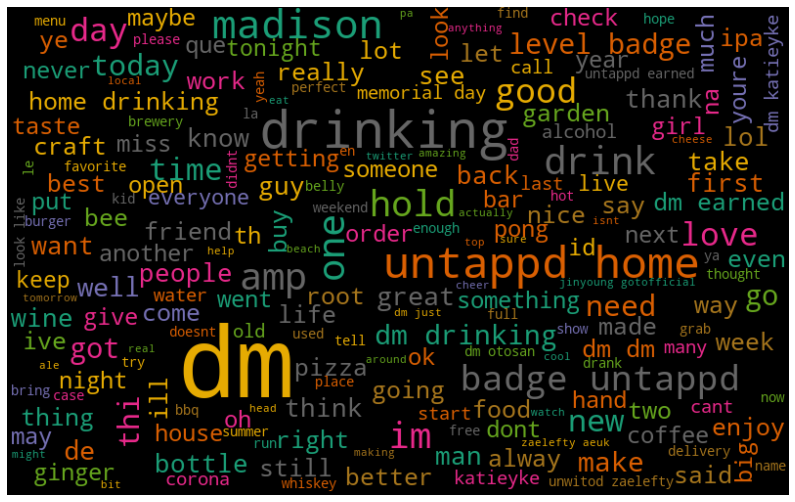

In [98]:
# create positive tweet word cloud (removes specified search terms, otherwise they would dominate)
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'pos']])
all_words = all_words.lower()
all_words = all_words.replace(search_terms, '')
generate_wordcloud(all_words)

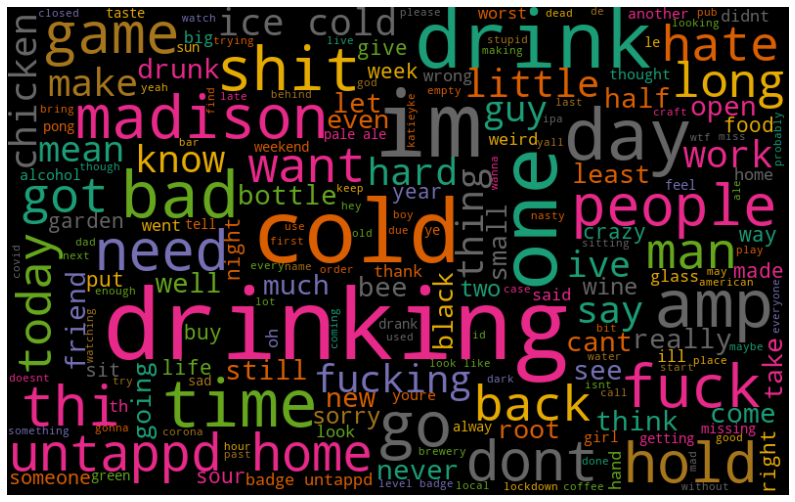

In [99]:
# create negative tweet word cloud 
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'neg']])
all_words = all_words.lower()
all_words = all_words.replace(search_terms, '')
generate_wordcloud(all_words)

In [117]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    d.to_csv(r'hashtags.csv', header=True, index=False)
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.savefig('hashtags.png')
    plt.show()
    

In [118]:
hashtags = hashtag_extract(tweets_df['tidy_tweets'])
hashtags = sum(hashtags, [])

C:\Users\XV60\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\XV60\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 40594 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\XV60\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 40607 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\XV60\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 2358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\XV60\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12499 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\XV

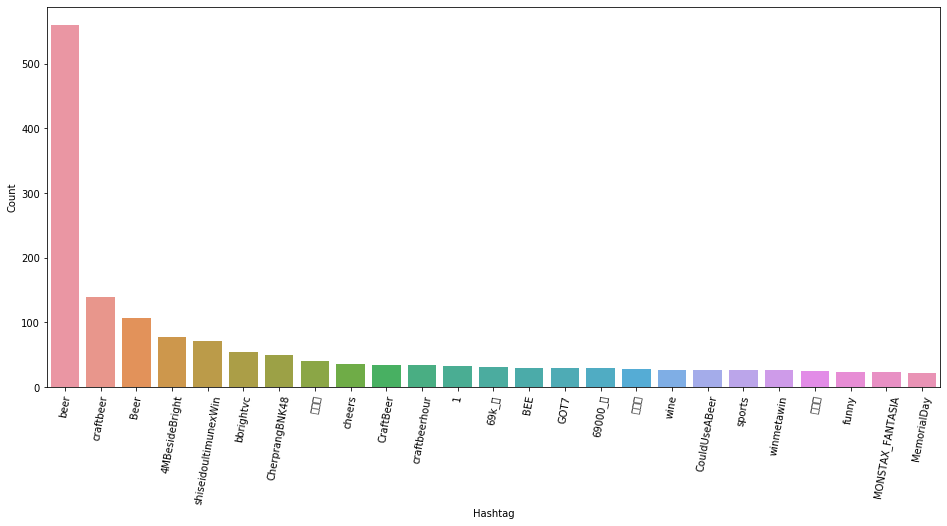

In [119]:
generate_hashtag_freqdist(hashtags)

In [109]:
# For sake of consistency, we are going to discard the records which contains no phrases i.e where tweets_df['key_phrases'] contains []
tweets_df2 = tweets_df[tweets_df['key_phrases'].str.len()>0]

In [110]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

In [111]:
phrase_sents = tweets_df2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

In [112]:
target_variable = tweets_df2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [116]:
# export to csv
tweets_df.to_csv(r'tweet_test.csv', header=True, index=False)